# 0. Marking and Guidelines
---
***IMPORTANT***

> The **attendance** and **active participation** in the **lab sessions** is **strongly recommended** and will be considered for grading.
>
> Save a copy of this notebook into your Drive before you start
> 
> Please attempt all the **questions** marked for your **group** (Part II ✅ | Part III/MPhil ✅).
> 
> Continue to **"Part 2"** after you are done with this **"Part 1"**.
>
> Please, provide your answers in a **new cell below the question cell**. You can make as many new cells as you need.

Please submit a `.zip` file, containing both parts, consisting of:
1. A text file with a **publicly** visible link to your notebooks in GitHub.
2. A **downloaded copy** (`.ipynb`) of your notebooks or your zipped cloned GitHub repo. You may treat these as a report---we will not be re-executing the code you used to produce the answers unless required.


Feel free to attempt more in case you find yourself enjoying the material!
If you have any questions, please ask them to the teaching assistants.
Are you interested in knowing more about federated learning and related topics? Reach out to the teaching assistants for additional resources and ask more about the current research projects.

## 1. Introduction
---

Welcome to the second lab session in our FL course.
We have already explored how to “federate” a centralized ML model.
You should now be able to understand who are the main actors in an FL orchestration.

In this lab, we will go a step further using all the tools we learned previously.
This lab will focus on the behaviour of an FL system under **heterogeneity**.
You may know that heterogeneity represents both an intrinsic property and a challenge in a real FL setting.
The literature agrees with splitting this property into two main categories.

- We will refer to **system heterogeneity** when the clients, or more generally the participants, of the federation, have very different hardware from each other. This may condition clients' availability and participation in FL rounds. _NOTE: the availability of clients could also depend on network conditions that are independent of the device's hardware. This particular heterogeneity will fall in this category as well._ In this lab, we will mostly refer to **data heterogeneity**. This occurs in those settings in which clients' datasets are non-i.i.d. (non-independent and identically distributed), which is the most frequent case. Even if it is quite obvious, it is worth saying that real distributed collections of data are intrinsically non-i.i.d. Thus creating more than a few statistical concerns on the convergence of widely used algorithms which assume i.i.d. samples.

_NOTE: for a more comprehensive discussion we suggest reading Sec.3.1 from [Advanced and Open Problems in Federated Learning](https://www.nowpublishers.com/article/Details/MAL-083)._


## 2. An overview of data heterogeneity
---

Data heterogeneity has been extensively investigated and characterized in statistics and other fields. Here we want to start with a quick overview of the flavours that come to light in FL:

- **Feature distribution skew**
- **Label distribution skew**
- **Quantity skew**
- _Same label, different features_
- _Same features, different label_
- _Violation of Independence_
- _Dataset Shift_

During this lab we will get into more detail about the first three categories only---those bolded.

It is crucial to say that a naturally partitioned dataset, also referred to as a "real FL dataset”, usually presents a combination of more than one of these properties. This enforces developers to take into account **all of these** during the building of the FL pipeline because in real settings **we cannot see or touch data**. I like to exemplify such a situation using a metaphor: data in FL are like a Schroedinger's cat for which we cannot open the cage. Before looking into the details of these flavours, let's install and load some useful packages.


In [ ]:
# `pip` could produce some errors. Do not worry about them.
# The execution has been verified; it's working anyway.
! pip install --quiet --upgrade "pip"
! pip install --quiet matplotlib tqdm seaborn
! pip install git+https://github.com/Iacob-Alexandru-Andrei/flower.git@teaching \
    torch torchvision ray=="2.6.3"
# The following is just needed to show the folder tree
! apt-get install -qq tree

: 

In [ ]:
# !wget https://github.com/ray-project/ray/archive/refs/tags/ray-2.6.3.zip
# !unzip ray-2.6.3.zip
# !cd ray-ray-2.6.3
# !pip install -r python/requirements.txt
# !pip install .

In [ ]:
# # download the `labs` folder from github
# !wget https://github.com/camlsys/L361-Federated-Learning/archive/release.zip
# !unzip release.zip
# !cp L361-Federated-Learning-release/labs . -r

In [ ]:
# !mv labs/common/ common/
# !rm -rf labs/

/home/poltor/miniconda3/envs/fedlearning/lib/python3.13/pty.py:95: DeprecationWarning: This process (pid=54245) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [1]:
import sys
import shutil
import random
import tarfile
from collections.abc import Callable
from copy import deepcopy
from pathlib import Path
from typing import Any, ClassVar
from types import MethodType
from logging import INFO

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np


import seaborn as sns
import pandas as pd
import torch
from torch import nn
from flwr.common.parameter import ndarrays_to_parameters
from flwr.common.typing import NDArrays, Parameters, Scalar
from flwr.common.logger import log
from flwr.server import ServerConfig, History
from flwr.server.strategy import FedAvg, Strategy
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
from enum import IntEnum
from flwr.client import Client
from flwr.server.client_proxy import ClientProxy
from flwr.common import FitRes, parameters_to_ndarrays

from common.femnist_dataset import FEMNIST
from common.client_utils import (
    to_tensor_transform,
    get_network_generator_mlp,
    get_network_generator_cnn,
    get_model_parameters,
    get_federated_evaluation_function,
    aggregate_weighted_average,
    get_device,
    save_history,
)
from common.lda_utils import create_lda_partitions
from common.client import FlowerClient, get_flower_client_generator


# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    """Seeds for reproducibility."""

    DEFAULT = 1337


def fit_client_seeded(
    client: FlowerClient,
    params: NDArrays,
    conf: dict[str, Any],
    seed: Seeds = Seeds.DEFAULT,
    **kwargs: Any,
) -> tuple[NDArrays, int, dict]:
    """Wrap to always seed client training."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return client.fit(params, conf, **kwargs)


np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

PathType = Path | str | None

/home/poltor/projects/uni/y3classes/modules/fedlearning/practical_labs/lab2_submission/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-15 19:28:05,427	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Another important ingredient, necessary to analyse heterogeneity, is a labelled dataset. We will use FEMNIST since we are all familiar with it now. We will initially load the same version of the dataset used in the previous lab, then we will start creating partitions at will.


In [5]:
home_dir = Path.cwd()
dataset_dir: Path = home_dir / "femnist"
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / "client_data_mappings" / "centralized"
centralized_mapping: Path = dataset_dir / "client_data_mappings" / "centralized" / "0"
federated_partition: Path = dataset_dir / "client_data_mappings" / "fed_natural"

In [6]:
def start_seeded_simulation(
    client_fn: Callable[[str], Client],
    num_clients: int,
    config: ServerConfig,
    strategy: Strategy,
    name: str,
    seed: int = Seeds.DEFAULT,
    iteration: int = 0,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Wrap simulation to always seed client selection."""
    np.random.seed(seed ^ iteration)
    torch.manual_seed(seed ^ iteration)
    random.seed(seed ^ iteration)
    parameter_list, hist = fl.simulation.start_simulation_no_ray(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources={},
        config=config,
        strategy=strategy,
    )
    save_history(home_dir, hist, name)
    return parameter_list, hist

In [7]:
# Decompress dataset
if not dataset_dir.exists():
    # print("no dataset!")
    with tarfile.open(home_dir / "femnist.tar.gz", "r:gz") as tar:
        tar.extractall(path=home_dir)
    log(INFO, "Dataset extracted in %s", dataset_dir)

We also need the dataset object. We will use the same as in the previous lab.


### 2.1 Feature distribution skew
---

Statisticians and data scientists refer to this property as "covariate shift”. It happens when different clients present samples which describe ideally the same objects having slightly different features. That is the case for two different writers hand-writing the same word, since these may have different stroke widths, slants, etc.
What happens to an FL setting in which this property is strong is not always predictable. Ideally, the global model, obtained using FedAvg, will try to learn a shared representation between clients. This could be problematic since clients have different features to represent their data. We could simply expect that the same seed model trained separately on local clients may perform better than a global model obtained in an FL training.

To see this property in our chosen dataset we will show two images for the same number taken from different clients.
_NOTE: the choice of clients and samples in the following is not random, but suitably made to show you the property._


INFO flwr 2025-02-15 19:29:01,452 | 2179019995.py:10 | For client 0, sample 4 has label 24
INFO flwr 2025-02-15 19:29:01,453 | 2179019995.py:11 | For client 1000, sample 0 has label 24


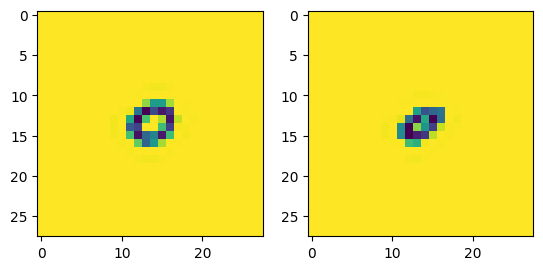

In [7]:
client_0_dataset: FEMNIST = FEMNIST(
    mapping=federated_partition / "0", data_dir=data_dir, name="train"
)
client_1000_dataset: FEMNIST = FEMNIST(
    mapping=federated_partition / "1000", data_dir=data_dir, name="train"
)
img_a, label_a = client_0_dataset[4]
img_b, label_b = client_1000_dataset[0]

log(INFO, f"For client 0, sample 4 has label {label_a}")
log(INFO, f"For client 1000, sample 0 has label {label_b}")
# display images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_a)
ax[1].imshow(img_b)

We can also compare the average values of all the features for all the samples of these clients having the label chosen. You can try to execute the cell below choosing different labels.


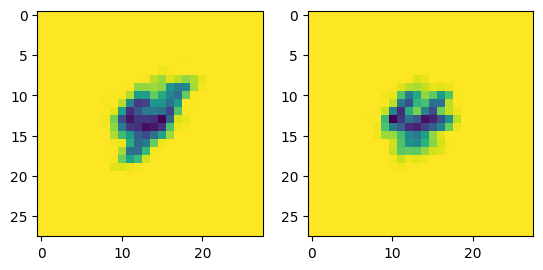

In [8]:
label_chosen = 4
features_0 = []
for img, lbl in client_0_dataset:
    if lbl == label_chosen:
        features_0.append(np.asarray(img).flatten())

features_1000 = []
for img, lbl in client_1000_dataset:
    if lbl == label_chosen:
        features_1000.append(np.asarray(img).flatten())

# display images
fig, ax = plt.subplots(1, 2)
ax[0].imshow((np.sum(features_0, axis=0) / len(features_0)).reshape((28, 28)))
ax[1].imshow((np.sum(features_1000, axis=0) / len(features_1000)).reshape((28, 28)))

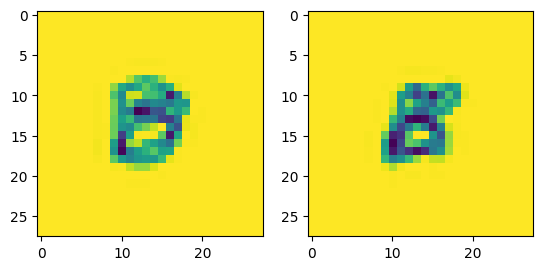

In [19]:
label_chosen = 11
features_0 = []
for img, lbl in client_0_dataset:
    if lbl == label_chosen:
        features_0.append(np.asarray(img).flatten())

features_1000 = []
for img, lbl in client_1000_dataset:
    if lbl == label_chosen:
        features_1000.append(np.asarray(img).flatten())

# display images
fig, ax = plt.subplots(1, 2)
ax[0].imshow((np.sum(features_0, axis=0) / len(features_0)).reshape((28, 28)))
ax[1].imshow((np.sum(features_1000, axis=0) / len(features_1000)).reshape((28, 28)))

It is worth having a glance on what are the consequences of this property on an FL experiment. To do that we will re-use the code for training an FL client from the previous lab.

In order to show on a small scale what can happen to FL training setups where clients have feature distribution skew, we will now build two toy settings. We choose the most populated client---the one with the most samples in the federation. We will then construct a second version of this same client by artificially changing its features by inverting the underlying images--- transforming each image into its negative. Furthermore, we need a specific `get_flower_client_generator` able to invert the images of a specific client.

In the following, we provide the relevant methods to do that. These methods are simplified taking advantage of the federation being composed of just two clients.


In [20]:
def load_femnist_inverted_dataset(mapping: Path, name: str) -> Dataset:
    """Load the filtered FEMNIST dataset given the mapping .csv file.

    The relevant transforms are automatically applied.
    Note that the last transform will invert images, getting their negative
    representation.

    Parameters
    ----------
        mapping (Path): path to the mapping .csv file chosen.
        name (str): name of the dataset to load, train or test.

    Returns
    -------
        Dataset: FEMNIST dataset object, ready to use.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.transforms.F.invert,
    ])

    return FEMNIST(
        mapping=mapping,
        name=name,
        data_dir=data_dir,
        transform=transform,
        target_transform=to_tensor_transform,
    )


# NOTE: We need the self to use this for replacing an internal of a class
def _load_inverted_dataset(self: FlowerClient, name: str) -> Dataset:
    """
    Load an inverted dataset for a specific client.

    This function loads the FEMNIST inverted dataset for the client identified by
    `self.cid`. The dataset is loaded from the partition directory specified by
    `self.partition_dir`.

    Parameters
    ----------
        name (str): The name of the dataset to load.

    Returns
    -------
        Dataset: The loaded inverted dataset.

    Raises
    ------
        FileNotFoundError: If the dataset file does not exist.
    """
    full_file: Path = self.partition_dir / str(self.cid)
    return load_femnist_inverted_dataset(mapping=full_file, name=name)


def get_mod_flower_client_generator(
    model_generator: Callable[[], Module],
    data_dir: Path,
    partition_dir: Path,
    mapping_fn: Callable[[int], int] | None = None,
) -> Callable[[str], FlowerClient]:
    """Wrap the function for the client instance generator.

    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    A mapping function could be used for filtering/ordering clients.
    Note that the "even" clients here will have a modified `_load_dataset` function.
    The new `_load_dataset` has been chosen to be the one inverting the images.

    Parameters
    ----------
        data_dir (Path): path to the dataset folder.
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Optional[Callable[[int], int]]): function mapping sorted/filtered
            ids to real cid.

    Returns
    -------
        Callable[[str], FlowerClient]: client instance.
    """

    def client_fn(cid: str) -> FlowerClient:
        """Create a single client instance given the client id `cid`.

        Parameters
        ----------
            cid (str): client id, Flower requires this to of type str.

        Returns
        -------
            FlowerClient: client instance.
        """
        log(INFO, f"Getting client with id {cid}")
        actual_cid = mapping_fn(int(cid)) if mapping_fn is not None else int(cid)
        client = FlowerClient(
            cid=actual_cid,
            data_dir=data_dir,
            partition_dir=partition_dir,
            model_generator=model_generator,
        )
        # Pay attention to the following two lines
        if int(cid) % 2 == 0:
            client._load_dataset = MethodType(_load_inverted_dataset, client)
        return client

    return client_fn

We will now try to train separately the two clients generated this way. The mapping function will be provided to point both client IDs to the data of the most populated client.

```python
mapping_dict = {0: '178', 1: '178'}
```

_NOTE: you may want *to experiment \_with \_different\_\_ clients here*. After having completed the lab, feel free to try!_

The following cell will set the relevant configuration for both training and testing of the client and its inverted version.

> **IMPORTANT: The architecture used here is an MLP because it is affected by inversion of images. Also, note that we must seed the model parameters here.**


In [21]:
# Seed the model
torch.manual_seed(Seeds.DEFAULT)
network_generator_mlp = get_network_generator_mlp()
seed_net_mlp = network_generator_mlp()
seed_model_mlp_params: NDArrays = get_model_parameters(seed_net_mlp)
# Set up config for both train and eval
train_config: dict[str, Any] = {
    "epochs": 8,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": None,
}
test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": None,
}
# Here is the mapping
mapping_dict = {0: "178", 1: "178"}
# NOTE: we are using here the `get_mod_flower_client_generator`
federated_mod_flower_client_generator: Callable[[str], FlowerClient] = (
    get_mod_flower_client_generator(
        model_generator=network_generator_mlp,
        data_dir=data_dir,
        partition_dir=federated_partition,
        mapping_fn=lambda x: int(mapping_dict[x]),
    )
)
# NOTE: we are using here the `get_flower_client_generator`
federated_flower_client_generator: Callable[[str], FlowerClient] = (
    get_flower_client_generator(
        model_generator=network_generator_mlp,
        data_dir=data_dir,
        partition_dir=federated_partition,
        mapping_fn=lambda x: int(mapping_dict[x]),
    )
)

Let's train separately the two versions of the client and then mutually evaluate their models.


In [22]:
# Create clients
client_0 = federated_mod_flower_client_generator(str(0))
client_1 = federated_mod_flower_client_generator(str(1))
# Fit client 0
client_0_params, *rest = fit_client_seeded(
    client_0, seed_model_mlp_params, train_config
)
log(INFO, f"Results of fitting the seed model on client 0:\n\t{rest}")
# Evaluate client 0 on model trained on client 0
client_0_res = client_0.evaluate(client_0_params, test_config)
log(
    INFO,
    "Results of model eval trained on client 0 on the test set of client 0:\n\t%s",
    client_0_res,
)
# Fit client 1
client_1_params, *rest = fit_client_seeded(
    client_1, seed_model_mlp_params, train_config
)
log(INFO, f"Results of fitting the seed model on client 1:\n\t{rest}")
# Evaluate client 1 on model trained on client 1
client_1_res = client_1.evaluate(client_1_params, test_config)
log(
    INFO,
    "Results of model eval trained on client 1 on the test set of client 1:\n\t%s",
    client_1_res,
)
# Evaluate client 0 on model trained on client 0
client_0_res = client_0.evaluate(client_1_params, test_config)
log(
    INFO,
    "Results of model eval trained on client 1 on the test set of client 0:\n\t%s",
    client_0_res,
)
# Evaluate client 1 on model trained on client 1
client_1_res = client_1.evaluate(client_0_params, test_config)
log(
    INFO,
    "Results of model eval trained on client 0 on the test set of client 1:\n\t%s",
    client_1_res,
)

INFO flwr 2025-02-15 19:31:45,156 | 3847737467.py:94 | Getting client with id 0
INFO flwr 2025-02-15 19:31:45,160 | client.py:51 | Creating client with cid: 178
INFO flwr 2025-02-15 19:31:45,162 | 3847737467.py:94 | Getting client with id 1
INFO flwr 2025-02-15 19:31:45,164 | client.py:51 | Creating client with cid: 178
INFO flwr 2025-02-15 19:31:47,814 | 1832891730.py:8 | Results of fitting the seed model on client 0:
	[13, {'train_loss': 0.012041637279952947}]
100%|██████████| 2/2 [00:00<00:00, 32.34it/s]
INFO flwr 2025-02-15 19:31:47,895 | 1832891730.py:11 | Results of model eval trained on client 0 on the test set of client 0:
	(3.58995521068573, 2, {'local_accuracy': 0.7446808510638298})
INFO flwr 2025-02-15 19:31:49,870 | 1832891730.py:20 | Results of fitting the seed model on client 1:
	[13, {'train_loss': 0.10809686378790782}]
100%|██████████| 2/2 [00:00<00:00, 55.18it/s]
INFO flwr 2025-02-15 19:31:49,930 | 1832891730.py:23 | Results of model eval trained on client 1 on the tes

In the following cell, we will set up all the relevant methods and parameters to run an FL simulation.


In [23]:
def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
    """
    Generate the training configuration for a given server round.

    This function updates the global training configuration with the current server
    round and returns the updated configuration.

    Parameters
    ----------
    server_round : int
        The current round of training on the server.

    Returns
    -------
    dict[str, Scalar]
        The updated training configuration dictionary.
    """
    train_config.update({"server_round": server_round})
    return train_config


def _on_evaluate_config_fn(server_round: int) -> dict[str, Scalar]:
    """
    Generate the evaluation configuration for a given server round.

    This function updates the global evaluation configuration with the current server
    round and returns the updated configuration.

    Parameters
    ----------
    server_round : int
        The current round of evaluation on the server.

    Returns
    -------
    dict[str, Scalar]
        The updated evaluation configuration dictionary.
    """
    test_config.update({"server_round": server_round})
    return test_config


# NOTE: We don't need the `federated_evaluation_function`. We care about the
# distributed accuracy, thus we skip centralised evaluation.
strategy = FedAvg(
    fraction_fit=sys.float_info.min,
    fraction_evaluate=sys.float_info.min,
    min_fit_clients=2,
    min_evaluate_clients=2,
    min_available_clients=2,
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=_on_evaluate_config_fn,
    initial_parameters=ndarrays_to_parameters(seed_model_mlp_params),
    accept_failures=False,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
)

### 2.2 Label distribution skew
---

The flavour of data heterogeneity we are dealing with in this subsection is often called “prior probability shift". In a few words, this occurs when, given a particular label, the distribution of samples having that label differs from client to client. In our running example, we can see whether in FEMNIST happens that different clients have drawn different distributions of symbols.
We can think about what could happen to an FL training in this situation simplifying a bit the actors in a play. Let's imagine that the federation has a subset of clients (one client: client 0) that is the only one having a specific subset of labels (say letters). A global model trained using FedAvg on that federation won't ever be able to learn well the representation of that subset of labels (letters). There exist methods to mitigate this particular situation, but often they involve sharing statistics about local datasets, thus creating privacy concerns.

We will select two clients, then we will plot the histogram of the labels for each of them on the same canvas. Thus, we will be able to evaluate whether there is a qualitative difference between the two.


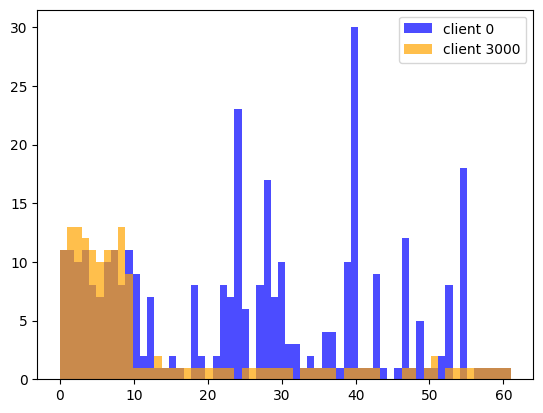

In [24]:
client_3000_dataset: FEMNIST = FEMNIST(
    mapping=federated_partition / "3000", data_dir=data_dir, name="train"
)
plt.hist(
    [int(x[1]) for x in client_0_dataset],
    bins=62,
    color="blue",
    alpha=0.7,
    label="client 0",
)
plt.hist(
    [int(x[1]) for x in client_3000_dataset],
    bins=62,
    color="orange",
    alpha=0.7,
    label="client 3000",
)
plt.legend()

---

**Question 1 (Part II ✅ | Part III/MPhil ✅):**

(These are meant to be conceptual questions. You should provide written answers for these. **No more than 3 sentences each**. **No code** is needed)

If we ignore the privacy assumptions of FL and allow the overall label distribution to be known, how could we balance the set of selected clients to guide the federated model towards a similar per-class accuracy that the centralised model can achieve? Assume FedAvg and the usual client implementation in your reasoning.

We could prioritise clients that has a distribution which resembles the centralised dataset, provided we know what that is. Alternatively, we could prioritise a more spread-out distribution across all the different classes (0 over 3000 in the above example). We could also try to select clients in such a way that their combined dataset each round contains a distribution of training examples that closely resemble the centralised dataset. 


---


### 2.3 Quantity skew
---

The last kind of heterogeneity we will discuss in detail is the _quantity skew_, which occurs when clients possess different numbers of samples. Last, but not least, it is the most investigated property that real FL datasets have. Also called "imbalancedness", it has been tackled using many techniques spanning from data manipulation to optimization algorithm design. Even if the literature regarding such techniques is quite broad, relative to FL being a new topic of research, there is still not any agreement about how to deal with imbalancedness. Often different solutions have different accuracy depending on the task and how imbalanced the FL dataset is.

Those of you that have well-trained observation skills may recall a plot in the last lab that spoiled this property. Now we'll try to get the global view of FEMNIST data from this perspective.


/tmp/ipykernel_86473/2496043336.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


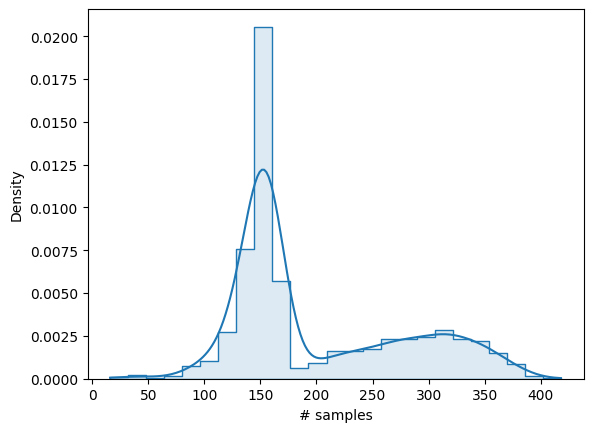

In [26]:
sns.histplot(
    alpha=0.15,
    legend=True,
    data=[
        len(
            FEMNIST(
                mapping=federated_partition / str(i), data_dir=data_dir, name="train"
            )
        )
        for i in range(3229)
    ],
    fill=True,
    kde=True,
    element="step",
    stat="density",
    common_norm=False,
    common_bins=True,
    cbar=True,
    palette="dark",
)
plt.xlabel("# samples")
plt.show()

## 3. The behaviour of FL under data heterogeneity/creating heterogeneous partitions
---


### FEMNIST folder structure
---

By default, FEMNIST will be split as follows:

- `femnist`: the location of the relevant data
  - `client_data_mappings`: contains different partitions
    - `centralized`: mappings from writer_id -> `[image_path, label]` for the centralized dataset
    - `fed_natural`: mappings from writer_id -> `[image_path, label]` for the naturally federated dataset
  - `data`: contains the macro partitions between test, train, and val
    - `train`: contains the raw images---samples of the train set
    - `test`: contains the raw images---samples of the test set
    - `val`: contains the raw images---samples of the val set
- `femnist.tar.gz`: the compressed dataset

We will store client datasets in sequentially labelled folders within each partition and do all necessary remapping in python.


In [27]:
# Showing resulting folder tree
! tree -dC -L 3 ./

/bin/bash: line 1: tree: command not found


### Test sets for FL
---

Prior to constructing our centralized partition, it is necessary to discuss what a test set even means for FL.

A testing set can generally be either a **federated test set** or a **local test set**:

- A federated test set contains data representative of the entire federated network and is used to provide a form of centralized-like evaluation of the federated model. In production scenarios, this would be data that has been consensually gathered from a multitude of users and is legal/efficient to store on the server or clients which have been kept out of the training loop. For research purposes it can be constructed in one of the two following ways:
  - Take x% of data from all clients and save it separately.
  - Leave y% of clients utterly unavailable for federated training and use their data as a test/validation set. **This is the version we shall use during the lab for the federated test set.**
- A local test set is formed via data from a specific client which has not been seen during training. There are as many local test sets as there are clients. As such, they can be used to test the model on a specific client or to accumulate average statistics to determine its performance.


### Creating and using partitions
---

#### Class imbalancedness
---

We will start creating class imbalanced partitions. The most representative example, as often happens, is the extreme one. Thus, we are going to create a partition of the dataset in which each client possesses one class only. This aim sets one parameter for the creation of the current partition, but we need to choose also another parameter: the number of clients we want to create or the number of samples per client that we want to infer. These last are two antagonist parameters that describe the same thing. The larger the number of clients is, the lower the number of samples per client is.

Let's start by looking at how labels are distributed in the entire dataset (test set only), by treating the dataset as centralized.


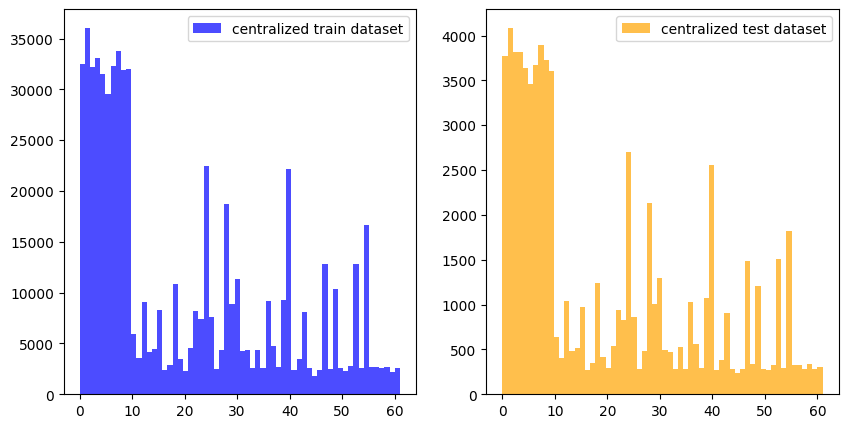

In [28]:
centralized_train_dataset: FEMNIST = FEMNIST(
    mapping=centralized_partition / "0", data_dir=data_dir, name="train"
)
centralized_test_dataset: FEMNIST = FEMNIST(
    mapping=centralized_partition / "0", data_dir=data_dir, name="test"
)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
train_histo = ax[0].hist(
    [int(x[1]) for x in centralized_train_dataset.data],
    bins=62,
    color="blue",
    alpha=0.7,
    label="centralized train dataset",
)
test_histo = ax[1].hist(
    [int(x[1]) for x in centralized_test_dataset.data],
    bins=62,
    color="orange",
    alpha=0.7,
    label="centralized test dataset",
)
ax[0].legend()
ax[1].legend()

Since the distribution is all but uniform, we need to make a further choice. We want to build a federation of 62 clients each of them having one class only. We want all the classes to be represented in the federation. Likewise, we also want FedAvg to treat equally all the clients in the federation. Thus, we will need to partition clients taking into account the population of the least represented class in both the `train` and the `test` set.


In [29]:
log(
    INFO,
    "The least represented class in the train set has %s samples",
    min(train_histo[0]),
)
log(
    INFO,
    "The least represented class in the test set has %s samples",
    min(test_histo[0]),
)
max_train_samples = int(min(train_histo[0]))
max_test_samples = int(min(test_histo[0]))

INFO flwr 2025-02-15 20:07:51,625 | 3870438806.py:1 | The least represented class in the train set has 1786.0 samples
INFO flwr 2025-02-15 20:07:51,629 | 3870438806.py:6 | The least represented class in the test set has 233.0 samples


Let's now create the function that creates the partition. We will stick to the folder structure the dataset has.


In [30]:
class_imbalanced_partition: Path = (
    dataset_dir / "client_data_mappings" / "class_imbalanced"
)
class_imbalanced_partition.mkdir(parents=True, exist_ok=True)
train_df = pd.read_csv(centralized_mapping / "train.csv")
test_df = pd.read_csv(centralized_mapping / "test.csv")
max_train_samples = 200
max_test_samples = 50
for i in range(62):
    folder_path: Path = class_imbalanced_partition / str(i)
    folder_path.mkdir(parents=True, exist_ok=True)

    train_path: Path = folder_path / "train.csv"
    test_path: Path = folder_path / "test.csv"

    client_df = deepcopy(
        train_df[train_df.label == i].sample(frac=1)[:max_train_samples]
    ).reset_index()
    client_df["client_id"] = i
    client_df = client_df.drop(columns=["level_0"])
    client_df.to_csv(train_path, index=False)
    client_df = deepcopy(
        test_df[test_df.label == i].sample(frac=1)[:max_test_samples]
    ).reset_index()
    client_df["client_id"] = i
    client_df = client_df.drop(columns=["level_0"])
    client_df.to_csv(test_path, index=False)

Here, we seed the initial model parameters to come from a partially trained model on the centralized dataset.


In [31]:
torch.manual_seed(Seeds.DEFAULT)
network_generator_cnn = get_network_generator_cnn()
seed_net_cnn = network_generator_cnn()
centralized_flower_client_generator: Callable[[str], FlowerClient] = (
    get_flower_client_generator(
        model_generator=network_generator_cnn,
        partition_dir=centralized_partition,
        data_dir=data_dir,
    )
)
centralized_flower_client = centralized_flower_client_generator(str(0))
centralized_train_config: dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 1000,
}
test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": None,
}
# Train parameters on the centralised dataset
trained_params, num_examples, train_metrics = fit_client_seeded(
    centralized_flower_client,
    params=get_model_parameters(seed_net_cnn),
    conf=centralized_train_config,
)
initial_parameters: Parameters = ndarrays_to_parameters(trained_params)

INFO flwr 2025-02-15 20:08:29,638 | client.py:51 | Creating client with cid: 0


We also create the centralised evaluation function that will be executed by the server at the end of every round if requested.


In [32]:
federated_evaluation_function = get_federated_evaluation_function(
    data_dir=data_dir,
    centralized_mapping=centralized_mapping,
    device=get_device(),
    batch_size=test_config["batch_size"],
    num_workers=test_config["num_workers"],
    model_generator=network_generator_cnn,
    criterion=nn.CrossEntropyLoss(),
)

INFO flwr 2025-02-15 20:09:04,587 | client_utils.py:423 | Reduced federated test_set size from 28510 to a size of 1500 mean index: 14726.628666666667


Finally, the client generator function.


In [33]:
imbalanced_flower_client_generator: Callable[[str], FlowerClient] = (
    get_flower_client_generator(
        model_generator=network_generator_cnn,
        data_dir=data_dir,
        partition_dir=class_imbalanced_partition,
    )
)

Let's see how these clients look like.


INFO flwr 2025-02-12 12:36:23,066 | client.py:51 | Creating client with cid: 0
INFO flwr 2025-02-12 12:36:23,110 | client.py:51 | Creating client with cid: 0


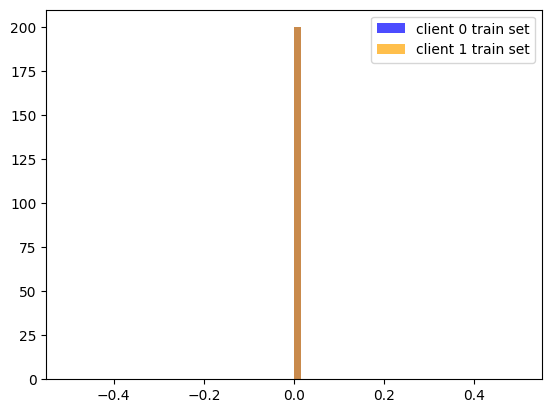

In [24]:
N_CLASSES = 62
train_dataset_client_0 = imbalanced_flower_client_generator(str(0))._load_dataset(
    "train"
)
plt.hist(
    [int(x[1]) for x in train_dataset_client_0.data],
    bins=N_CLASSES,
    color="blue",
    alpha=0.7,
    label="client 0 train set",
)
train_dataset_client_1 = imbalanced_flower_client_generator(str(0))._load_dataset(
    "train"
)
plt.hist(
    [int(x[1]) for x in train_dataset_client_1.data],
    bins=N_CLASSES,
    color="orange",
    alpha=0.7,
    label="client 1 train set",
)
plt.legend()

We will now create a wrapper for the strategy that will be used to extract the clients' model parameters obtained during the training for the next question.


In [141]:
class WrappedFedAvg(FedAvg):
    """Wrap the FedAvg strategy to store clients' models."""

    clients_models: ClassVar[dict[int, list[tuple[int, NDArrays]]]] = {}
    results = {}

    def aggregate_fit(
        self,
        server_round: int,
        results: list[tuple[ClientProxy, FitRes]],
        failures: list[tuple[ClientProxy, FitRes] | BaseException],
    ) -> tuple[Parameters | None, dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        # Call FedAvg original aggregate_fit, so that it handles the failures
        ret = super().aggregate_fit(server_round, results, failures)
        # Append clients' model parameters to the list

        self.results[server_round] = results
        
        self.clients_models[server_round] = [
            (i, parameters_to_ndarrays(fit_res.parameters))
            for i, (_, fit_res) in enumerate(results)
        ]
        # Return the original return value
        return ret

In [142]:
train_config: dict[str, Any] = {
    "epochs": 8,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": None,
}


def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
    train_config.update({"server_round": server_round})
    return train_config


num_total_clients = 62
num_clients_per_round: int = 5
num_evaluate_clients: int = 5

strategy = WrappedFedAvg(
    fraction_fit=sys.float_info.min,
    fraction_evaluate=sys.float_info.min,
    min_fit_clients=num_clients_per_round,
    min_evaluate_clients=num_evaluate_clients,
    min_available_clients=max(num_clients_per_round, num_evaluate_clients),
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=None,
    evaluate_fn=federated_evaluation_function,
    initial_parameters=initial_parameters,
    accept_failures=False,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
)

In [143]:
params, hist = start_seeded_simulation(
    client_fn=lambda cid: imbalanced_flower_client_generator(cid).to_client(),
    num_clients=num_total_clients,
    config=ServerConfig(num_rounds=5),
    strategy=strategy,
    name="imbalanced",
)

INFO flwr 2025-02-17 11:11:34,952 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO flwr 2025-02-17 11:11:34,954 | server_returns_parameters.py:81 | Initializing global parameters
INFO flwr 2025-02-17 11:11:34,956 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2025-02-17 11:11:34,958 | server_returns_parameters.py:84 | Evaluating initial parameters
100%|██████████| 47/47 [00:00<00:00, 128.31it/s]
INFO flwr 2025-02-17 11:11:35,330 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 58.9051810503006, {'accuracy': 0.5913333333333334}
INFO flwr 2025-02-17 11:11:35,331 | server_returns_parameters.py:97 | FL starting
DEBUG flwr 2025-02-17 11:11:35,331 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 62)
INFO flwr 2025-02-17 11:11:35,332 | client.py:51 | Creating client with cid: 39
INFO flwr 2025-02-17 11:11:35,333 | client.py:51 | C

We will now investigate how such a partition behaves in an FL setting. In particular, we will try to understand what happens to the global model and the clients' updates as the training progresses.


---

**Question 2 (Part II ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

1. For each round, retrieve the clients' models and the global model using the appropriate attribute of the `WrappedFedAvg` strategy.
2. Inspect the models collected for each round as follows:
   - Extract the "softmax-ed" activations of the last layer of each clients' model when the model is fed with random inputs. (HINT: `from common.client_utils import get_activations_from_random_input`, give a motivation for the choice of the parameters of this function if you decide to use it)
   - Compute the pairwise cosine-similarity (you can use functions similar to those used in the previous Lab) between the values obtained in the previous step.
   - Plot the results of this computation in a confusion matrix. The confusion matrix will have the shape `n_clients_per_round`x`n_clients_per_round`.
   - Repeat the same procedure for computing and compare the pairwise KL divergence between the "softmax-ed" activations of the last layer of each clients' model when the model is fed with random inputs. (HINT: `from scipy.stats import entropy`).
3. Compare the confusion matrices obtained. What do you observe, and how does it compare with your expectations? Briefly discuss the results.

---


In [191]:
from common.client_utils import get_activations_from_random_input
import numpy.typing as npt
from matplotlib import pyplot as plt
import matplotlib as mpl

len(strategy.clients_models) # indexed by round -> index from 0 to 4 -> (client index, NDArrays)

# Copy over the cosine_similarity functions from Lab 1
def cosine_similarity(vec1: npt.NDArray, vec2: npt.NDArray):
    '''
    We compute the cosine_similarity between two 1-D vectors x, y as
    x dot y / ||X|| ||Y||

    because x dot y = ||X|| ||Y|| cos (theta)
    '''
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def flatten(ndarrays: NDArrays):
    '''
    Given a list of numpy NDArray objects, we flatten all the elements
    into a single 1-D vector
    '''
    result = np.concatenate([x.reshape(-1) for x in ndarrays])
    return result

def get_parameters_cosine_similarity(params1: NDArrays, params2: NDArrays):
    '''
    Calculates the cosine similarity between two
    model parameters (NDArrays) by flattening them and
    performing cosine similarity
    '''

    params1_1d = flatten(params1)
    params2_1d = flatten(params2)

    # Check that the two vectors are of the same dimensions
    assert params1_1d.shape == params2_1d.shape

    return cosine_similarity(params1_1d, params2_1d)


def plot_similarity_matrix(similarity_matrix: npt.NDArray, 
                           title:str=None, 
                           model_names:str=None):
    n_models=len(similarity_matrix)

    # Plot the colour squares
    fix, ax = plt.subplots()
    im = ax.imshow(similarity_matrix, cmap=mpl.cm.Blues)
    plt.colorbar(im)

    if title:
        plt.title(title)

    # Add the axis labels onto the figure
    ax.set_xticks(np.arange(n_models))
    ax.set_yticks(np.arange(n_models))
    if model_names:
        assert len(model_names) == n_models
        ax.set_xticklabels(model_names, rotation=45, ha="right")
        ax.set_yticklabels(model_names)

    # Add the cell labels
    for i in range(similarity_matrix.shape[0]):
        for j in range(similarity_matrix.shape[1]):
            text = f"{similarity_matrix[i, j]:.4f}"
            ax.text(j, i, text, ha="center", va="center", color="black")
    plt.show()

Sanity check to make sure all the model parameters have the expected shape

In [179]:
def get_model_shape(model: NDArrays):
    return tuple([q.shape for q in model])

sample_model_params = strategy.clients_models[1][0][1]
model_shape = get_model_shape(sample_model_params)
print(model_shape)

for models_per_round in strategy.clients_models.values():
    for model_per_client in models_per_round:
        assert get_model_shape(model_per_client[1]) == model_shape

((6, 1, 5, 5), (6,), (16, 6, 5, 5), (16,), (120, 256), (120,), (84, 120), (84,), (62, 84), (62,))


Create a fresh CNN for each trained model and copy the parameters over

In [196]:
from collections import OrderedDict

def ndarrays_to_state_dict(parameters_ndarrays: NDArrays, 
                           reference_state_dict: OrderedDict[str, torch.tensor]):
    '''
    Construct a pytorch `state_dict` given parameters from NDArrays.
    '''

    new_state_dict = OrderedDict()
    # print("Model layers=", reference_state_dict.keys())

    for idx, (layer_name, generated_parameters) in enumerate(reference_state_dict.items()):
        new_state_dict[layer_name] = \
            torch.tensor(parameters_ndarrays[idx])
        assert generated_parameters.shape == parameters_ndarrays[idx].shape

    return new_state_dict


If we visualise the activations (by uncommenting the code below), we can see that every model has a spike in the isolated class that they were trained on. This makes sense, because when all the model sees is Class X, it will learn to minimise loss by only predicting Class X and nothing else.



In [200]:
def get_round_activations(round_idx):
    # Create a list to store the activations per round
    round_activations: list[npt.NDArray] = [] 

    for model_per_client in strategy.clients_models[round_idx]:
        
        network_generator_cnn = get_network_generator_cnn()
        new_cnn = network_generator_cnn()
        copied_state_dict = ndarrays_to_state_dict(model_per_client[1], new_cnn.state_dict())
        new_cnn.load_state_dict(copied_state_dict)

        activations = get_activations_from_random_input(new_cnn, get_device(), 100, 1337)
        round_activations.append(activations)

        # Plot the activations to check if it is what we expect
        # plt.figure(figsize=(15, 6))
        # plt.plot(activations)

        # for i in range(62):
        #     plt.axvline(x=i, color='gray', linestyle='-', alpha=0.5)
    return round_activations

In [207]:
def plot_round_activations_similarity_matrix(round_idx, title=None):

    round_activations = get_round_activations(round_idx)

    # Make everyone an NDArrays so I do not have to rewrite my Lab 1 code

    round_activations_ndarrays = [[x] for x in round_activations] 

    similarity_matrix = np.zeros((num_clients_per_round, num_clients_per_round))
    for idx_i, i in enumerate(round_activations_ndarrays):
        for idx_j, j in enumerate(round_activations_ndarrays):
            cosine = get_parameters_cosine_similarity(i, j)
            similarity_matrix[idx_i][idx_j] = cosine

    plot_similarity_matrix(similarity_matrix, title=title)


The activation of each model is going to be very strong in its own class and near-zero everywhere else. For all pairs of distinct models, the class they were trained on was different. 

It makes sense that taking the cosine similarity of these output vectors will produce a result near-zero, which is what we would expect in the similarity matrices.

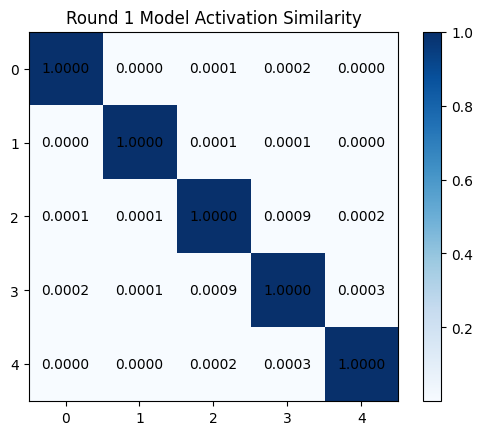

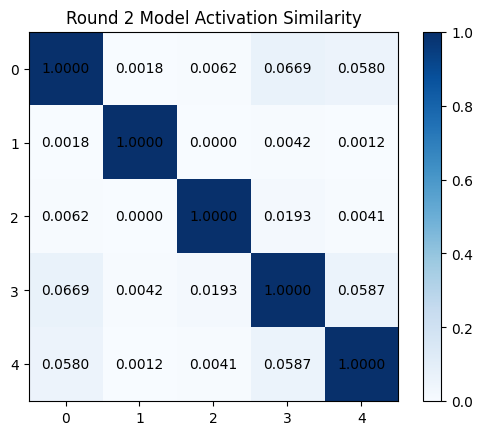

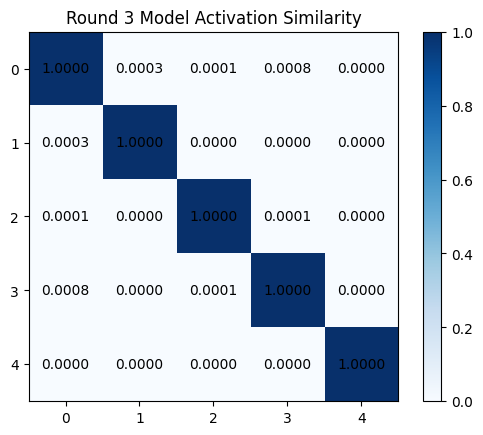

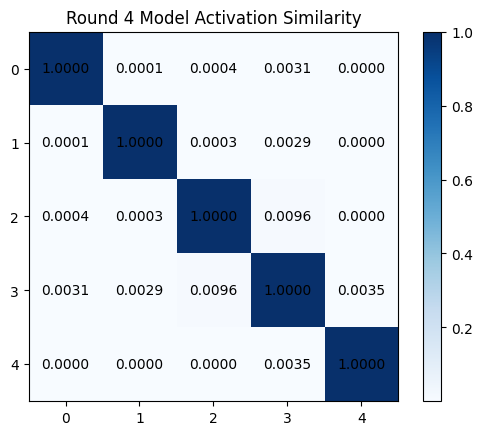

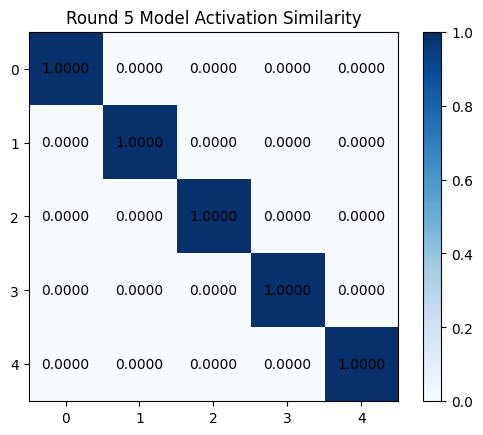

In [209]:
for i in range(1, 6):
    plot_round_activations_similarity_matrix(i, title=f'Round {i} Model Activation Similarity')


---

**Question 3 (Part III/MPhil ✅):**

(This is meant to be a conceptual question. You should provide a written answer to this. **No more than 3 sentences**. **No code** is needed)

1. Read about Multi-task Learning (MTL) [here](https://academic.oup.com/nsr/article/5/1/30/4101432). How does the concept of a client relate to a task in MTL?

---


#### LDA partitions
---

The most popular method for creating heterogeneous partitions from a centralized dataset in terms of class unbalancing is [Latent Dirichlet Allocation (LDA)](https://web.archive.org/web/20120501152722/http://jmlr.csail.mit.edu/papers/v3/blei03a.html). LDA is a generative probabilistic model for collections of discrete data. The paper linked above provides all the theoretical details about the method.

The important detail for you to understand about LDA is that the `concentration` parameter controls the degree of heterogeneity in the distribution while `num_partitions` controls how many clients are generated following the specified distribution.

A `concentration=0` implies a completely heterogeneous distribution where each client may only contain examples from one class. Thus, if for a `concentration=0` we were to set the `num_partitions` argument to the number of classes we will get the same partitioning as the one we manually created above.

> **Important:** The LDA partitioning only approaches a fully i.i.d distribution when `concentration` tends towards $\infty$. The most appropriate value of the `concentration` to generate a completely i.i.d. partition is dataset dependent. Feel free to try out different values of `concentration` and `num_partitions` to see how the partitioning changes.


Let's create the partitions using LDA with `concentration=2.5` and `num_partitions=1000`. This will result in a non-i.i.d. partitioning.


In [210]:
N_TOTAL_CLIENTS = 1_000
concentration = 2.5
# Create partitions
x = np.array([x[0] for x in centralized_train_dataset.data])
y = np.array([x[1] for x in centralized_train_dataset.data])
train_clients_partitions, dist = create_lda_partitions(
    dataset=(x, y),
    dirichlet_dist=None,
    num_partitions=N_TOTAL_CLIENTS,
    concentration=concentration,
    accept_imbalanced=True,
    seed=Seeds.DEFAULT,
)
x = np.array([x[0] for x in centralized_test_dataset.data])
y = np.array([x[1] for x in centralized_test_dataset.data])
test_clients_partitions, dist = create_lda_partitions(
    dataset=(x, y),
    dirichlet_dist=dist,
    num_partitions=N_TOTAL_CLIENTS,
    concentration=concentration,
    accept_imbalanced=True,
    seed=Seeds.DEFAULT,
)

Let's store the partitions in the folder structure we have been using so far.


In [211]:
lda_partition: Path = dataset_dir / "client_data_mappings" / "lda"
if lda_partition.exists():
    shutil.rmtree(str(lda_partition))
lda_partition.mkdir(parents=True, exist_ok=True)

for i, (train_set, test_set) in enumerate(
    zip(train_clients_partitions, test_clients_partitions, strict=True)
):
    folder_path: Path = lda_partition / str(i)
    folder_path.mkdir(parents=True, exist_ok=True)

    train_path: Path = folder_path / "train.csv"
    test_path: Path = folder_path / "test.csv"

    pd.DataFrame({
        "client_id": [0] * len(train_set[0]),
        "sample_path": train_set[0],
        "sample_id": range(len(train_set[0])),
        "label": train_set[1],
    }).to_csv(train_path, index=False, mode="w")
    pd.DataFrame({
        "client_id": [0] * len(test_set[0]),
        "sample_path": test_set[0],
        "sample_id": range(len(test_set[0])),
        "label": test_set[1],
    }).to_csv(test_path, index=False, mode="w")

We instantiate a client generator function.


In [212]:
lda_flower_client_generator: Callable[[str], FlowerClient] = (
    get_flower_client_generator(
        model_generator=network_generator_cnn,
        data_dir=data_dir,
        partition_dir=lda_partition,
    )
)

We can also plot two clients' labels distributions to see how different they are.


INFO flwr 2025-02-17 11:42:14,380 | client.py:51 | Creating client with cid: 0
INFO flwr 2025-02-17 11:42:14,418 | client.py:51 | Creating client with cid: 1


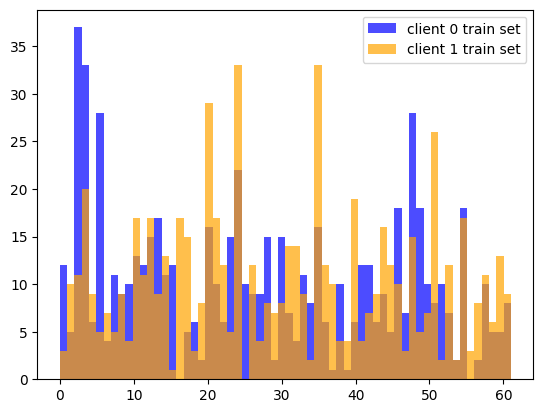

In [213]:
N_CLASSES = 62
plt.hist(
    [
        int(x[1])
        for x in lda_flower_client_generator(str(0))._load_dataset("train").data
    ],
    bins=N_CLASSES,
    color="blue",
    alpha=0.7,
    label="client 0 train set",
)
plt.hist(
    [
        int(x[1])
        for x in lda_flower_client_generator(str(1))._load_dataset("train").data
    ],
    bins=N_CLASSES,
    color="orange",
    alpha=0.7,
    label="client 1 train set",
)
plt.legend()

We try now to run an FL simulation is such challenging setting.


In [214]:
train_config: dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": None,
}


def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
    """
    Generate the training configuration for a given server round.

    This function updates the global training configuration with the current server
    round and returns the updated configuration.

    Parameters
    ----------
    server_round : int
        The current round of training on the server.

    Returns
    -------
    dict[str, Scalar]
        The updated training configuration dictionary.
    """
    train_config.update({"server_round": server_round})
    return train_config


num_total_clients = N_TOTAL_CLIENTS
num_clients_per_round: int = 5
num_evaluate_clients: int = 0

strategy = FedAvg(
    fraction_fit=sys.float_info.min,
    fraction_evaluate=sys.float_info.min,
    min_fit_clients=num_clients_per_round,
    min_evaluate_clients=num_evaluate_clients,
    min_available_clients=max(num_clients_per_round, num_evaluate_clients),
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=None,
    evaluate_fn=federated_evaluation_function,
    initial_parameters=initial_parameters,
    accept_failures=False,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
)

In [215]:
params, hist = start_seeded_simulation(
    client_fn=lambda cid: lda_flower_client_generator(cid).to_client(),
    num_clients=num_total_clients,
    config=ServerConfig(num_rounds=5),
    strategy=strategy,
    name="fedavg_lda_example",
)

INFO flwr 2025-02-17 11:42:30,697 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO flwr 2025-02-17 11:42:30,702 | server_returns_parameters.py:81 | Initializing global parameters
INFO flwr 2025-02-17 11:42:30,703 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2025-02-17 11:42:30,704 | server_returns_parameters.py:84 | Evaluating initial parameters
100%|██████████| 47/47 [00:00<00:00, 203.73it/s]
INFO flwr 2025-02-17 11:42:30,942 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 58.9051810503006, {'accuracy': 0.5913333333333334}
INFO flwr 2025-02-17 11:42:30,942 | server_returns_parameters.py:97 | FL starting
DEBUG flwr 2025-02-17 11:42:30,943 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 1000)
INFO flwr 2025-02-17 11:42:30,943 | client.py:51 | Creating client with cid: 632
INFO flwr 2025-02-17 11:42:30,943 | client.py:51 

---

**Question 4 (Part II ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

1. Produce a set of LDA partitions with `concentration` in `[0.001, 0.1, 1e3]`.
2. Train an FL setting for every partition you have produced using the same hyperparameter we used in the cell above, but with `num_clients_per_round=62` and `ServerConfig(num_rounds=1)`.
3. Why do you think one-shot averaging works well for full i.i.d. data and not for very heterogeneous clients?

---


Use the configuration provided by the following cell.

> **IMPORTANT**: Be careful when using the strategy object. You must ensure that the different experiments will use the same initial parameters. Inspect `flwr.server.strategy.FedAvg` to understand how these are used.


In [217]:
# Create all the LDA partitions 

N_TOTAL_CLIENTS = 1_000
concentrations = [0.001, 0.1, 1e3]

for concentration in concentrations:
    # Create partitions
    x = np.array([x[0] for x in centralized_train_dataset.data])
    y = np.array([x[1] for x in centralized_train_dataset.data])
    train_clients_partitions, dist = create_lda_partitions(
        dataset=(x, y),
        dirichlet_dist=None,
        num_partitions=N_TOTAL_CLIENTS,
        concentration=concentration,
        accept_imbalanced=True,
        seed=Seeds.DEFAULT,
    )
    x = np.array([x[0] for x in centralized_test_dataset.data])
    y = np.array([x[1] for x in centralized_test_dataset.data])
    test_clients_partitions, dist = create_lda_partitions(
        dataset=(x, y),
        dirichlet_dist=dist,
        num_partitions=N_TOTAL_CLIENTS,
        concentration=concentration,
        accept_imbalanced=True,
        seed=Seeds.DEFAULT,
    )

    lda_partition: Path = dataset_dir / "client_data_mappings" / f"lda-{concentration}"
    if lda_partition.exists():
        shutil.rmtree(str(lda_partition))
    lda_partition.mkdir(parents=True, exist_ok=True)

    for i, (train_set, test_set) in enumerate(
        zip(train_clients_partitions, test_clients_partitions, strict=True)
    ):
        folder_path: Path = lda_partition / str(i)
        folder_path.mkdir(parents=True, exist_ok=True)

        train_path: Path = folder_path / "train.csv"
        test_path: Path = folder_path / "test.csv"

        pd.DataFrame({
            "client_id": [0] * len(train_set[0]),
            "sample_path": train_set[0],
            "sample_id": range(len(train_set[0])),
            "label": train_set[1],
        }).to_csv(train_path, index=False, mode="w")
        pd.DataFrame({
            "client_id": [0] * len(test_set[0]),
            "sample_path": test_set[0],
            "sample_id": range(len(test_set[0])),
            "label": test_set[1],
        }).to_csv(test_path, index=False, mode="w")

In [216]:
# NOTE: We are using randomly initialized parameters here.
torch.manual_seed(Seeds.DEFAULT)
network_generator_cnn = get_network_generator_cnn()
seed_net_cnn = network_generator_cnn()
q4_initial_parameters: Parameters = ndarrays_to_parameters(
    get_model_parameters(seed_net_cnn)
)
# Set up experiment configuration
N_TOTAL_CLIENTS = 100
N_TOTAL_ROUNDS = 1
train_config: dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.001,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": None,
}


def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
    """
    Generate the training configuration for a given server round.

    This function updates the global training configuration with the current server
    round and returns the updated configuration.

    Parameters
    ----------
    server_round : int
        The current round of training on the server.

    Returns
    -------
    dict[str, Scalar]
        The updated training configuration dictionary.
    """
    train_config.update({"server_round": server_round})
    return train_config


num_total_clients = N_TOTAL_CLIENTS
num_clients_per_round: int = 62
num_evaluate_clients: int = 0
fraction_fit: float = float(num_clients_per_round) / num_total_clients
fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients
# Set up strategy
strategy = FedAvg(
    fraction_fit=sys.float_info.min,
    fraction_evaluate=sys.float_info.min,
    min_fit_clients=num_clients_per_round,
    min_evaluate_clients=num_evaluate_clients,
    min_available_clients=max(num_clients_per_round, num_evaluate_clients),
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=None,
    evaluate_fn=federated_evaluation_function,
    initial_parameters=q4_initial_parameters,
    accept_failures=False,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
)

In [219]:
lda_flower_client_generator: Callable[[str], FlowerClient] = (
    get_flower_client_generator(
        model_generator=network_generator_cnn,
        data_dir=data_dir,
        partition_dir=dataset_dir / "client_data_mappings" / "lda-0.001",
    )
)

params, hist = start_seeded_simulation(
    client_fn=lambda cid: lda_flower_client_generator(cid).to_client(),
    num_clients=num_total_clients,
    config=ServerConfig(num_rounds=1),
    strategy=strategy,
    name="fedavg_lda_example",
)

INFO flwr 2025-02-17 12:06:37,346 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2025-02-17 12:06:37,349 | server_returns_parameters.py:81 | Initializing global parameters
INFO flwr 2025-02-17 12:06:37,351 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2025-02-17 12:06:37,354 | server_returns_parameters.py:84 | Evaluating initial parameters
100%|██████████| 47/47 [00:00<00:00, 188.44it/s]
INFO flwr 2025-02-17 12:06:37,609 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 194.37576389312744, {'accuracy': 0.004}
INFO flwr 2025-02-17 12:06:37,609 | server_returns_parameters.py:97 | FL starting
DEBUG flwr 2025-02-17 12:06:37,610 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 62 clients (out of 100)
INFO flwr 2025-02-17 12:06:37,611 | client.py:51 | Creating client with cid: 79
INFO flwr 2025-02-17 12:06:37,611 | client.py:51 | Creating c

In [224]:
lda_flower_client_generator: Callable[[str], FlowerClient] = (
    get_flower_client_generator(
        model_generator=network_generator_cnn,
        data_dir=data_dir,
        partition_dir=dataset_dir / "client_data_mappings" / "lda-0.1",
    )
)

params, hist = start_seeded_simulation(
    client_fn=lambda cid: lda_flower_client_generator(cid).to_client(),
    num_clients=num_total_clients,
    config=ServerConfig(num_rounds=1),
    strategy=strategy,
    name="fedavg_lda_example",
)

INFO flwr 2025-02-17 12:09:10,659 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2025-02-17 12:09:10,662 | server_returns_parameters.py:81 | Initializing global parameters
INFO flwr 2025-02-17 12:09:10,663 | server_returns_parameters.py:277 | Requesting initial parameters from one random client
INFO flwr 2025-02-17 12:09:10,664 | client.py:51 | Creating client with cid: 79
INFO flwr 2025-02-17 12:09:10,666 | server_returns_parameters.py:281 | Received initial parameters from one random client
INFO flwr 2025-02-17 12:09:10,668 | server_returns_parameters.py:84 | Evaluating initial parameters
100%|██████████| 47/47 [00:00<00:00, 115.02it/s]
INFO flwr 2025-02-17 12:09:11,081 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 194.37576389312744, {'accuracy': 0.004}
INFO flwr 2025-02-17 12:09:11,082 | server_returns_parameters.py:97 | FL starting
DEBUG flwr 2025-02-17 12:09:11,084 | server_returns_parame

In [225]:
lda_flower_client_generator: Callable[[str], FlowerClient] = (
    get_flower_client_generator(
        model_generator=network_generator_cnn,
        data_dir=data_dir,
        partition_dir=dataset_dir / "client_data_mappings" / "lda-1000.0",
    )
)

params, hist = start_seeded_simulation(
    client_fn=lambda cid: lda_flower_client_generator(cid).to_client(),
    num_clients=num_total_clients,
    config=ServerConfig(num_rounds=1),
    strategy=strategy,
    name="fedavg_lda_example",
)

INFO flwr 2025-02-17 12:09:29,712 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2025-02-17 12:09:29,713 | server_returns_parameters.py:81 | Initializing global parameters
INFO flwr 2025-02-17 12:09:29,714 | server_returns_parameters.py:277 | Requesting initial parameters from one random client
INFO flwr 2025-02-17 12:09:29,714 | client.py:51 | Creating client with cid: 79
INFO flwr 2025-02-17 12:09:29,718 | server_returns_parameters.py:281 | Received initial parameters from one random client
INFO flwr 2025-02-17 12:09:29,719 | server_returns_parameters.py:84 | Evaluating initial parameters
100%|██████████| 47/47 [00:00<00:00, 182.56it/s]
INFO flwr 2025-02-17 12:09:29,980 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 194.37576389312744, {'accuracy': 0.004}
INFO flwr 2025-02-17 12:09:29,980 | server_returns_parameters.py:97 | FL starting
DEBUG flwr 2025-02-17 12:09:29,981 | server_returns_parame

## 4. FL Strategies tackling heterogeneity
---

The challenge of dealing with non-iidness in FL has been discussed extensively since the publication of the first paper about FL. Many approaches have been proposed, but still, the literature doesn't agree on a general approach or a rule of thumb. A natural method is to modify/extend FedAvg or develop another algorithm specifically oriented to mitigating heterogeneity. In some applications, augmenting data to make it more similar between clients is possible. Some works assume a small dataset that is shared between clients to serve as a reference.

Every time a new approach has been proposed, many related questions have arisen. It is no longer clear that treating all examples of all the clients equally make sense. Some works proposed limiting the contributions of data from any client in the federation. The notion of fairness has been introduced and defined in many ways in order to set up principles that could result in new approaches, for example emphasizing underperforming clients during aggregation. It is not even clear whether a single global model is the correct objective for FL---works related to this question gave birth to Personalised Federated Learning (PFL), a sub-branch of research.

We started to think that we should be able to turn the non-iid problem from a bug into a feature treated similarly to a task in MTL. The number of works that start with this perspective is however limited.

Even if FedAvg can partially mitigate heterogeneity, it is not working well in all situations, as we saw previously. From the many new algorithms that were introduced, it is worth mentioning: [FedProx](https://www.researchgate.net/profile/Anit-Sahu/publication/329734586_On_the_Convergence_of_Federated_Optimization_in_Heterogeneous_Networks/links/5c1bdd5e299bf12be38ee52d/On-the-Convergence-of-Federated-Optimization-in-Heterogeneous-Networks.pdf), [q-FedAvg](https://arxiv.org/abs/1905.10497), [SCAFFOLD](http://proceedings.mlr.press/v119/karimireddy20a.html). For a matter of time, we will now explore just one of these algorithms introduced for tackling the non-iid problem specifically. We chose FedProx since it is the simplest to demonstrate.


### FedProx
---

The Federated Proximal (FedProx) method was developed in the context of tuning and benchmarking FedAvg in a heterogeneous setting. The authors of FedAvg proposed carefully tuning the learning rate and the number of local epochs to increase the accuracy in such settings but turned out clear that something more was necessary. Based on the client's heterogeneity, local updates change the global model not only in different directions in the loss space but also at different rates. This phenomenon is called client divergence or drifting.

Using FedAvg we would like to have a different number of local epochs for each client based on its characteristics. Thus, heuristically setting the number of local updates is not always optimal, because clients are all different from each other. Limiting the number of local updates through a more flexible tool is beneficial. Thus, FedProx proposes to incorporate a term in the local objective function that penalizes big changes from the current model at the server. In each node $k$, instead of minimizing the local loss function $F_k$, the local solver tries to approximately minimize:

$\min_wh_w(w;w^t)=F_k(w)+\frac{\mu}{2}||w-w^t||^2$,

where $||w-w^t||^2$ is the new proximal term.

FedProx acts as FedAvg apart from the change in the local objective. This new objective enforces limited local model updates more explicitly than FedAvg. Using FedProx, it is no longer necessary to tune the number of local epochs for each client to minimize divergence.

We will now implement and test FedProx on the natural partition of FEMNIST. Implementing FedProx just involves modifying the local training function of our `FlowerRayClient`. We will then write the new function and build a new `client_generator` function that overwrites the relevant methods of our client.


In [227]:
def train_fedprox_femnist(
    net: Module,
    train_loader: DataLoader,
    epochs: int,
    device: str,
    optimizer: torch.optim.Optimizer,
    criterion: Module,
    proximal_mu: float,
) -> float:
    """Train the network on the training set using FedProx.

    Parameters
    ----------
        net (Module): generic module object describing the network to train.
        train_loader (DataLoader): dataloader to iterate during the training.
        epochs (int): number of epochs of training.
        device (str): device name onto which perform the computation.
        optimizer (torch.optim.Optimizer): optimizer object.
        criterion (Module): generic module describing the loss function.
        proximal_mu (float): parameter for the weight of the proximal term.

    Returns
    -------
        float: the final epoch mean train loss.
    """
    global_params: Module = deepcopy(net)
    global_params.requires_grad_(False)
    global_params_list = [val for _, val in global_params.state_dict().items()]
    net.train()
    running_loss, total = 0.0, 0
    for _ in tqdm(range(epochs)):
        running_loss = 0.0
        total = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            # NOTE: here comes the implementation of FedProx algorithm
            proximal_term = 0.0
            for local_weights, global_weights in zip(
                net.parameters(), global_params_list, strict=True
            ):
                proximal_term += (local_weights - global_weights).norm(2)
            loss = criterion(net(data), labels) + (proximal_mu / 2) * proximal_term
            running_loss += loss.item()
            total += labels.size(0)
            loss.backward()
            optimizer.step()
    return running_loss / total


def _train_fedprox(
    self: FlowerClient, net: Module, train_loader: DataLoader, config: dict[str, Scalar]
) -> float:
    return train_fedprox_femnist(
        net=net,
        train_loader=train_loader,
        epochs=int(config["epochs"]),
        device=self.device,
        optimizer=torch.optim.AdamW(
            net.parameters(),
            lr=float(config["client_learning_rate"]),
            weight_decay=float(config["weight_decay"]),
        ),
        criterion=torch.nn.CrossEntropyLoss(),
        proximal_mu=float(config["proximal_mu"]),
    )


def get_fedprox_flower_client_generator(
    model_generator: Callable[[], Module],
    data_dir: Path,
    partition_dir: Path,
) -> Callable[[str], FlowerClient]:
    """Implement a wrapper function for the client instance generator.

    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    The clients generated will train using FedProx algorithm.

    Parameters
    ----------
        data_dir (Path): path to the dataset folder.
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.

    Returns
    -------
        Callable[[str], WrappedClient]: client instance.
    """

    def client_fn(cid: str) -> FlowerClient:
        """Create a single client instance given the client id `cid`.

        Parameters
        ----------
            cid (str): client id, Flower requires this to of type str.

        Returns
        -------
            WrappedClient: client instance.
        """
        log(INFO, f"Getting client with id {cid}")
        client = FlowerClient(
            cid=int(cid),
            data_dir=data_dir,
            partition_dir=partition_dir,
            model_generator=model_generator,
        )
        # Pay attention to the following line
        client._train = MethodType(_train_fedprox, client)
        return client

    return client_fn

In [228]:
torch.manual_seed(Seeds.DEFAULT)
N_TOTAL_CLIENTS = 1000
CONCENTRATION = 0.1
# Create partitions
x = np.array([x[0] for x in centralized_train_dataset.data])
y = np.array([x[1] for x in centralized_train_dataset.data])
train_clients_partitions, dist = create_lda_partitions(
    dataset=(x, y),
    dirichlet_dist=None,
    num_partitions=N_TOTAL_CLIENTS,
    concentration=CONCENTRATION,
    accept_imbalanced=True,
    seed=Seeds.DEFAULT,
)
x = np.array([x[0] for x in centralized_test_dataset.data])
y = np.array([x[1] for x in centralized_test_dataset.data])
test_clients_partitions, dist = create_lda_partitions(
    dataset=(x, y),
    dirichlet_dist=dist,
    num_partitions=N_TOTAL_CLIENTS,
    concentration=CONCENTRATION,
    accept_imbalanced=True,
)
# Store partitions
lda_partition: Path = dataset_dir / "client_data_mappings" / f"lda_{CONCENTRATION}"
if lda_partition.exists():
    shutil.rmtree(str(lda_partition))
lda_partition.mkdir(parents=True, exist_ok=True)

for i, (train_set, test_set) in enumerate(
    zip(train_clients_partitions, test_clients_partitions, strict=True)
):
    folder_path: Path = lda_partition / str(i)
    folder_path.mkdir(parents=True, exist_ok=True)

    train_path: Path = folder_path / "train.csv"
    test_path: Path = folder_path / "test.csv"

    pd.DataFrame({
        "client_id": [0] * len(train_set[0]),
        "sample_path": train_set[0],
        "sample_id": range(len(train_set[0])),
        "label": train_set[1],
    }).to_csv(train_path, index=False)
    pd.DataFrame({
        "client_id": [0] * len(test_set[0]),
        "sample_path": test_set[0],
        "sample_id": range(len(test_set[0])),
        "label": test_set[1],
    }).to_csv(test_path, index=False)

We are now able to train an FL setting using FedProx.


In [229]:
# NOTE: we are using here the `get_fedprox_flower_client_generator`
federated_fedprox_flower_client_generator: Callable[[str], FlowerClient] = (
    get_fedprox_flower_client_generator(
        model_generator=network_generator_cnn,
        data_dir=data_dir,
        partition_dir=lda_partition,
    )
)
N_TOTAL_ROUNDS = 5
# Set up experiment configuration
train_config: dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.1,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": None,
    "proximal_mu": 0.01,
}


def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
    train_config.update({"server_round": server_round})
    return train_config


num_total_clients = N_TOTAL_CLIENTS
num_clients_per_round: int = 5
num_evaluate_clients: int = 0
fraction_fit: float = float(num_clients_per_round) / num_total_clients
fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients
# Set up strategy
strategy = FedAvg(
    fraction_fit=sys.float_info.min,
    fraction_evaluate=sys.float_info.min,
    min_fit_clients=num_clients_per_round,
    min_evaluate_clients=num_evaluate_clients,
    min_available_clients=max(num_clients_per_round, num_evaluate_clients),
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=None,
    evaluate_fn=federated_evaluation_function,
    initial_parameters=initial_parameters,
    accept_failures=False,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
)

In [230]:
params_list, hist = start_seeded_simulation(
    client_fn=lambda cid: federated_fedprox_flower_client_generator(cid).to_client(),
    num_clients=N_TOTAL_CLIENTS,
    config=ServerConfig(num_rounds=N_TOTAL_ROUNDS),
    strategy=strategy,
    name="fedprox",
)

INFO flwr 2025-02-17 16:14:18,581 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO flwr 2025-02-17 16:14:18,589 | server_returns_parameters.py:81 | Initializing global parameters
INFO flwr 2025-02-17 16:14:18,591 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2025-02-17 16:14:18,595 | server_returns_parameters.py:84 | Evaluating initial parameters
100%|██████████| 47/47 [00:00<00:00, 64.59it/s]
INFO flwr 2025-02-17 16:14:19,331 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 58.9051810503006, {'accuracy': 0.5913333333333334}
INFO flwr 2025-02-17 16:14:19,332 | server_returns_parameters.py:97 | FL starting
DEBUG flwr 2025-02-17 16:14:19,333 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 1000)
INFO flwr 2025-02-17 16:14:19,334 | 2358598921.py:102 | Getting client with id 632
INFO flwr 2025-02-17 16:14:19,335 | 2358598921.p

---

**Question 5 (Part II ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

1. Train the FL setting composed of LDA partitions with `concentration=1.0` using FedProx with values of `proximal_mu` in $\{10.0, 0.1, 1e-5\}$. Keep `num_clients_per_round=5` and `ServerConfig(num_rounds=10)`. Use the experimental configurations bellow.
2. Plot the norm of the pseudo-gradient (average delta between the updated models and models at the start of the round) and the loss (in two plots) for every `proximal_mu`. What do you observe, and how does it compare with your expectations? Briefly discuss the results.

---


In [231]:
torch.manual_seed(Seeds.DEFAULT)
network_generator_cnn = get_network_generator_cnn()
seed_net_cnn = network_generator_cnn()
centralized_flower_client_generator: Callable[[str], FlowerClient] = (
    get_flower_client_generator(
        model_generator=network_generator_cnn,
        partition_dir=centralized_partition,
        data_dir=data_dir,
    )
)
centralized_flower_client = centralized_flower_client_generator(0)
centralized_train_config: dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 1000,
}
# Train parameters on the centralised dataset
trained_params, num_examples, train_metrics = fit_client_seeded(
    centralized_flower_client,
    params=get_model_parameters(seed_net_cnn),
    conf=centralized_train_config,
)
q5_initial_parameters_pretrained = ndarrays_to_parameters(trained_params)

INFO flwr 2025-02-17 16:16:40,156 | client.py:51 | Creating client with cid: 0


In [238]:
N_TOTAL_CLIENTS = 1000
N_TOTAL_ROUNDS = 10
N_CLIENTS_PER_ROUND = 5
CONCENTRATION = 1.0
# Set up experiment configuration

def get_strategy_from_proximal_mu(proximal_mu):
    train_config: dict[str, Any] = {
        "epochs": 5,
        "batch_size": 32,
        "client_learning_rate": 0.01,
        "weight_decay": 0.001,
        "num_workers": 0,
        "max_batches": None,
        # NOTE: This must be adjusted according to the requests
        "proximal_mu": proximal_mu,
    }


    def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
        """
        Generate the training configuration for a given server round.

        This function updates the global training configuration with the current server
        round and returns the updated configuration.

        Parameters
        ----------
        server_round : int
            The current round of training on the server.

        Returns
        -------
        dict[str, Scalar]
            The updated training configuration dictionary.
        """
        train_config.update({"server_round": server_round})
        return train_config


    num_total_clients = N_TOTAL_CLIENTS
    num_clients_per_round: int = N_CLIENTS_PER_ROUND
    num_evaluate_clients: int = 0
    fraction_fit: float = float(num_clients_per_round) / num_total_clients
    fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients
    # Set up strategy
    strategy = FedAvg(
        fraction_fit=sys.float_info.min,
        fraction_evaluate=sys.float_info.min,
        min_fit_clients=num_clients_per_round,
        min_evaluate_clients=num_evaluate_clients,
        min_available_clients=max(num_clients_per_round, num_evaluate_clients),
        on_fit_config_fn=_on_fit_config_fn,
        on_evaluate_config_fn=None,
        evaluate_fn=federated_evaluation_function,
        initial_parameters=q5_initial_parameters_pretrained,
        accept_failures=False,
        fit_metrics_aggregation_fn=aggregate_weighted_average,
        evaluate_metrics_aggregation_fn=aggregate_weighted_average,
    )
    return strategy

# Create partitions
x = np.array([x[0] for x in centralized_train_dataset.data])
y = np.array([x[1] for x in centralized_train_dataset.data])
train_clients_partitions, dist = create_lda_partitions(
    dataset=(x, y),
    dirichlet_dist=None,
    num_partitions=N_TOTAL_CLIENTS,
    concentration=CONCENTRATION,
    accept_imbalanced=True,
)
x = np.array([x[0] for x in centralized_test_dataset.data])
y = np.array([x[1] for x in centralized_test_dataset.data])
test_clients_partitions, dist = create_lda_partitions(
    dataset=(x, y),
    dirichlet_dist=dist,
    num_partitions=N_TOTAL_CLIENTS,
    concentration=CONCENTRATION,
    accept_imbalanced=True,
)
# Store partitions
lda_partition: Path = dataset_dir / "client_data_mappings" / f"lda_{CONCENTRATION}"
if lda_partition.exists():
    shutil.rmtree(str(lda_partition))
lda_partition.mkdir(parents=True, exist_ok=True)

for i, (train_set, test_set) in enumerate(
    zip(train_clients_partitions, test_clients_partitions, strict=True)
):
    folder_path: Path = lda_partition / str(i)
    folder_path.mkdir(parents=True, exist_ok=True)

    train_path: Path = folder_path / "train.csv"
    test_path: Path = folder_path / "test.csv"

    pd.DataFrame({
        "client_id": [0] * len(train_set[0]),
        "sample_path": train_set[0],
        "sample_id": range(len(train_set[0])),
        "label": train_set[1],
    }).to_csv(train_path, index=False)
    pd.DataFrame({
        "client_id": [0] * len(test_set[0]),
        "sample_path": test_set[0],
        "sample_id": range(len(test_set[0])),
        "label": test_set[1],
    }).to_csv(test_path, index=False)
# Create the client generator
fedprox_flower_client_generator: Callable[[str], FlowerClient] = (
    get_fedprox_flower_client_generator(
        model_generator=network_generator_cnn,
        data_dir=data_dir,
        partition_dir=lda_partition,
    )
)

In [239]:
strategy_10 = get_strategy_from_proximal_mu(10.0)
strategy_e_1 = get_strategy_from_proximal_mu(0.1)
strategy_e_5 = get_strategy_from_proximal_mu(1e-5)


In [240]:
params_list_10, hist_10 = start_seeded_simulation(
    client_fn=lambda cid: federated_fedprox_flower_client_generator(cid).to_client(),
    num_clients=N_TOTAL_CLIENTS,
    config=ServerConfig(num_rounds=N_TOTAL_ROUNDS),
    strategy=strategy_10,
    name="fedprox",
)

params_list_e_1, hist_e_1 = start_seeded_simulation(
    client_fn=lambda cid: federated_fedprox_flower_client_generator(cid).to_client(),
    num_clients=N_TOTAL_CLIENTS,
    config=ServerConfig(num_rounds=N_TOTAL_ROUNDS),
    strategy=strategy_10,
    name="fedprox",
)

params_list_e_5, hist_e_5 = start_seeded_simulation(
    client_fn=lambda cid: federated_fedprox_flower_client_generator(cid).to_client(),
    num_clients=N_TOTAL_CLIENTS,
    config=ServerConfig(num_rounds=N_TOTAL_ROUNDS),
    strategy=strategy_10,
    name="fedprox",
)

INFO flwr 2025-02-17 16:32:09,373 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flwr 2025-02-17 16:32:09,381 | server_returns_parameters.py:81 | Initializing global parameters
INFO flwr 2025-02-17 16:32:09,383 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2025-02-17 16:32:09,387 | server_returns_parameters.py:84 | Evaluating initial parameters
100%|██████████| 47/47 [00:00<00:00, 64.20it/s]
INFO flwr 2025-02-17 16:32:10,130 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 58.9051810503006, {'accuracy': 0.5913333333333334}
INFO flwr 2025-02-17 16:32:10,131 | server_returns_parameters.py:97 | FL starting
DEBUG flwr 2025-02-17 16:32:10,134 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 1000)
INFO flwr 2025-02-17 16:32:10,136 | 2358598921.py:102 | Getting client with id 632
INFO flwr 2025-02-17 16:32:10,138 | 2358598921.

In [242]:
hist_10

History (loss, centralized):
	round 0: 58.9051810503006
	round 1: 58.57088214159012
	round 2: 58.18745136260986
	round 3: 57.87424075603485
	round 4: 57.677363872528076
	round 5: 57.22206777334213
	round 6: 56.93297702074051
	round 7: 56.53614521026611
	round 8: 56.46922731399536
	round 9: 56.39719748497009
	round 10: 56.11180359125137
History (metrics, distributed, fit):
{'train_loss': [(1, {'avg': 0.051302207820117476, 'all': [(20, 0.04790849015116692), (20, 0.04157508034259081), (20, 0.04887398742139339), (20, 0.0631171764805913), (20, 0.055036304704844954)]}), (2, {'avg': 0.061485839821398255, 'all': [(20, 0.05591779947280884), (20, 0.07797207534313202), (20, 0.07102580219507218), (20, 0.05802365317940712), (20, 0.04448986891657114)]}), (3, {'avg': 0.06217369060963392, 'all': [(20, 0.06132271643728018), (20, 0.04821757227182388), (20, 0.0845472663640976), (20, 0.05080065298825502), (20, 0.06598024498671293)]}), (4, {'avg': 0.05979362353682518, 'all': [(20, 0.06195592656731606), (20

In [244]:
hist_e_1

History (loss, centralized):
	round 0: 194.37576389312744
	round 1: 194.36924171447754
	round 2: 194.36631202697754
	round 3: 194.35533046722412
	round 4: 194.3468713760376
	round 5: 194.33701133728027
	round 6: 194.33685493469238
	round 7: 194.33332633972168
	round 8: 194.32882452011108
	round 9: 194.31562995910645
	round 10: 194.3170771598816
History (metrics, distributed, fit):
{'train_loss': [(1, {'avg': 0.15450257301330567, 'all': [(20, 0.15664943531155587), (20, 0.15549012646079063), (20, 0.15322361662983894), (20, 0.15383244454860687), (20, 0.153317242115736)]}), (2, {'avg': 0.1552705216407776, 'all': [(20, 0.15583213195204734), (20, 0.15351716950535774), (20, 0.15423522740602494), (20, 0.15862749963998796), (20, 0.15414057970046996)]}), (3, {'avg': 0.1554579445719719, 'all': [(20, 0.15700006484985352), (20, 0.15388350635766984), (20, 0.1570884183049202), (20, 0.1527857668697834), (20, 0.1565319664776325)]}), (4, {'avg': 0.15466853871941566, 'all': [(20, 0.15465285927057265), (2

In [266]:
get_model_shape(params_list_10[0][1])

((6, 1, 5, 5),
 (6,),
 (16, 6, 5, 5),
 (16,),
 (120, 256),
 (120,),
 (84, 120),
 (84,),
 (62, 84),
 (62,))

In [280]:
# From lab 1
def get_average_gradients(trained_params_list: list[tuple[int, NDArrays]]):
    # List[11] of Tuple(round_idx, List[10] of NDArray )

    def difference_in_parameters(params1, params2):
        return [i - j for i, j in zip(params1, params2)]

    reconstituted_gradients = [difference_in_parameters(i[1], j[1])
        for i, j in zip(trained_params_list[:-1], trained_params_list[1:])]

    reconstituted_gradient = reconstituted_gradients[0]

    average_gradients = []
    for reconstituted_gradient in reconstituted_gradients:

        assert len(reconstituted_gradient) == 10
        average_gradient = sum([np.linalg.norm(layer) for layer in reconstituted_gradient]) \
            / len(reconstituted_gradient)
        average_gradients.append(average_gradient)
    return average_gradients

In [281]:
params_list_10[0][1][0].shape    

(6, 1, 5, 5)

In [282]:
average_gradients_10 = get_average_gradients(params_list_10)
average_gradients_e_1 = get_average_gradients(params_list_e_1)
average_gradients_e_5 = get_average_gradients(params_list_e_5) 

Text(0.5, 1.0, 'Average gradients for mu=10')

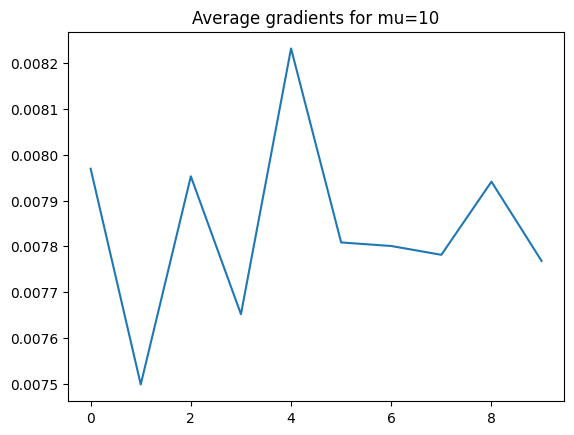

In [285]:
plt.plot(average_gradients_10)
plt.title('Average gradients for mu=10')

Text(0.5, 1.0, 'Average gradients for mu=1e-1')

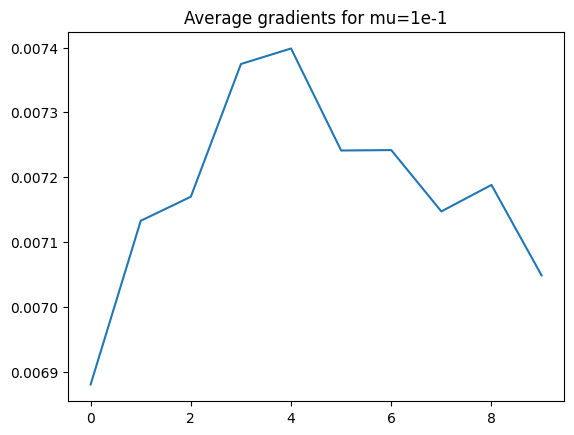

In [287]:
plt.plot(average_gradients_e_1)
plt.title('Average gradients for mu=1e-1')

Text(0.5, 1.0, 'Average gradients for mu=1e-5')

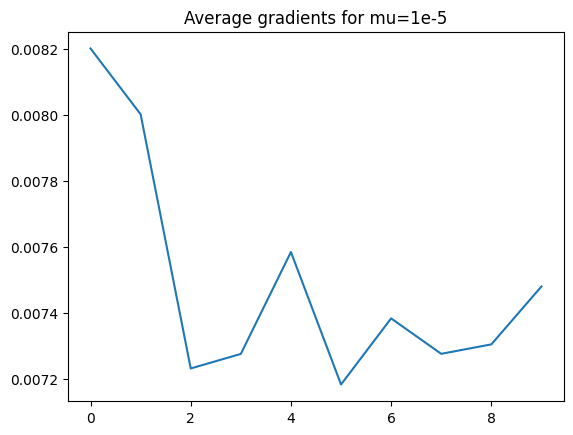

In [288]:
plt.plot(average_gradients_e_5)
plt.title('Average gradients for mu=1e-5')

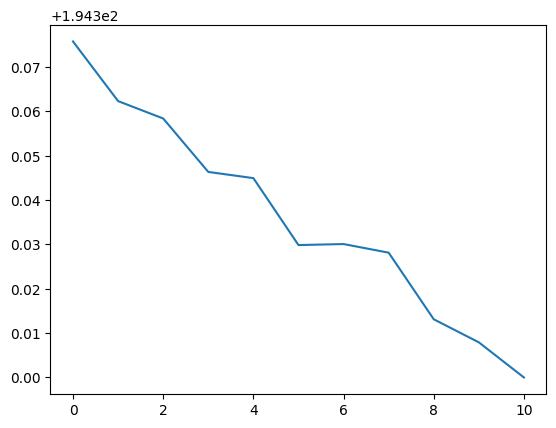

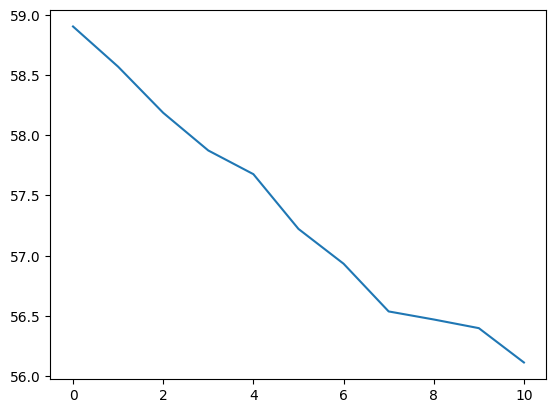

In [290]:

plt.plot([i[1] for i in hist_10.losses_centralized])

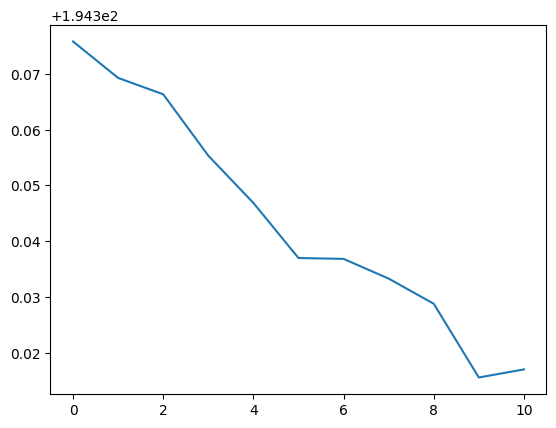

In [291]:
plt.plot([i[1] for i in hist_e_1.losses_centralized])

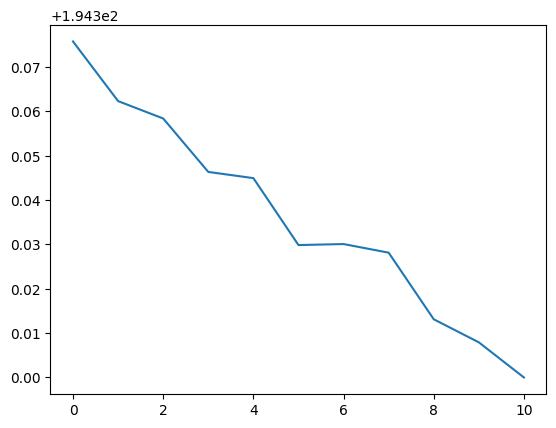

In [292]:
plt.plot([i[1] for i in hist_e_5.losses_centralized])

---

**Question 6 (Part III/MPhil ✅):**

(These are meant to be conceptual questions. You should provide written answers for these. **No more than 3 sentences each**. No code is needed)

In FL, fairness is generally defined as the variance of the accuracy of the global model on local clients' test sets. If two models have the same average accuracy, the one with the lower variance between clients is the fairer.

- In light of this, is it reasonable to say that analysing the fairness of the model across clients, i.e. the distributed accuracy, could be used as a tool to measure the data heterogeneity? Motivate your answer.
- Both FedAvg and FedProx are training a single global model, so we will always measure some unfairness. Do you think we could improve fairness by finetuning the global model on the local clients just before evaluating it on their local test set?

---

(c) 2025 Alexandru-Andrei Iacob, Lorenzo Sani
